# Contrôle de TP Apprentissage Automatique 1

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Imports



In [ ]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [ ]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [ ]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2024-05-06 01:52:37--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  5.00MB/s    in 60s     

2024-05-06 01:53:37 (2.05 MB/s) - ‘dataset.zip’ saved [128685900/128685900]



La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [ ]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))

                    # add associated label
                    labels.append(idx)

    # mélange les données
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [ ]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 27.6 s, sys: 7.87 s, total: 35.4 s
Wall time: 43.4 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [ ]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[96] = 3 -> crying_baby
• y_train[34] = 1 -> clock_tick
• y_train[86] = 2 -> crackling_fire
• y_train[166] = 5 -> helicopter
• y_train[128] = 4 -> dog
• y_train[206] = 6 -> rain
• y_train[19] = 0 -> chainsaw
• y_train[224] = 7 -> rooster
• y_train[158] = 4 -> dog
• y_train[302] = 9 -> sneezing


**Affichage de quelques spectrogrammes**


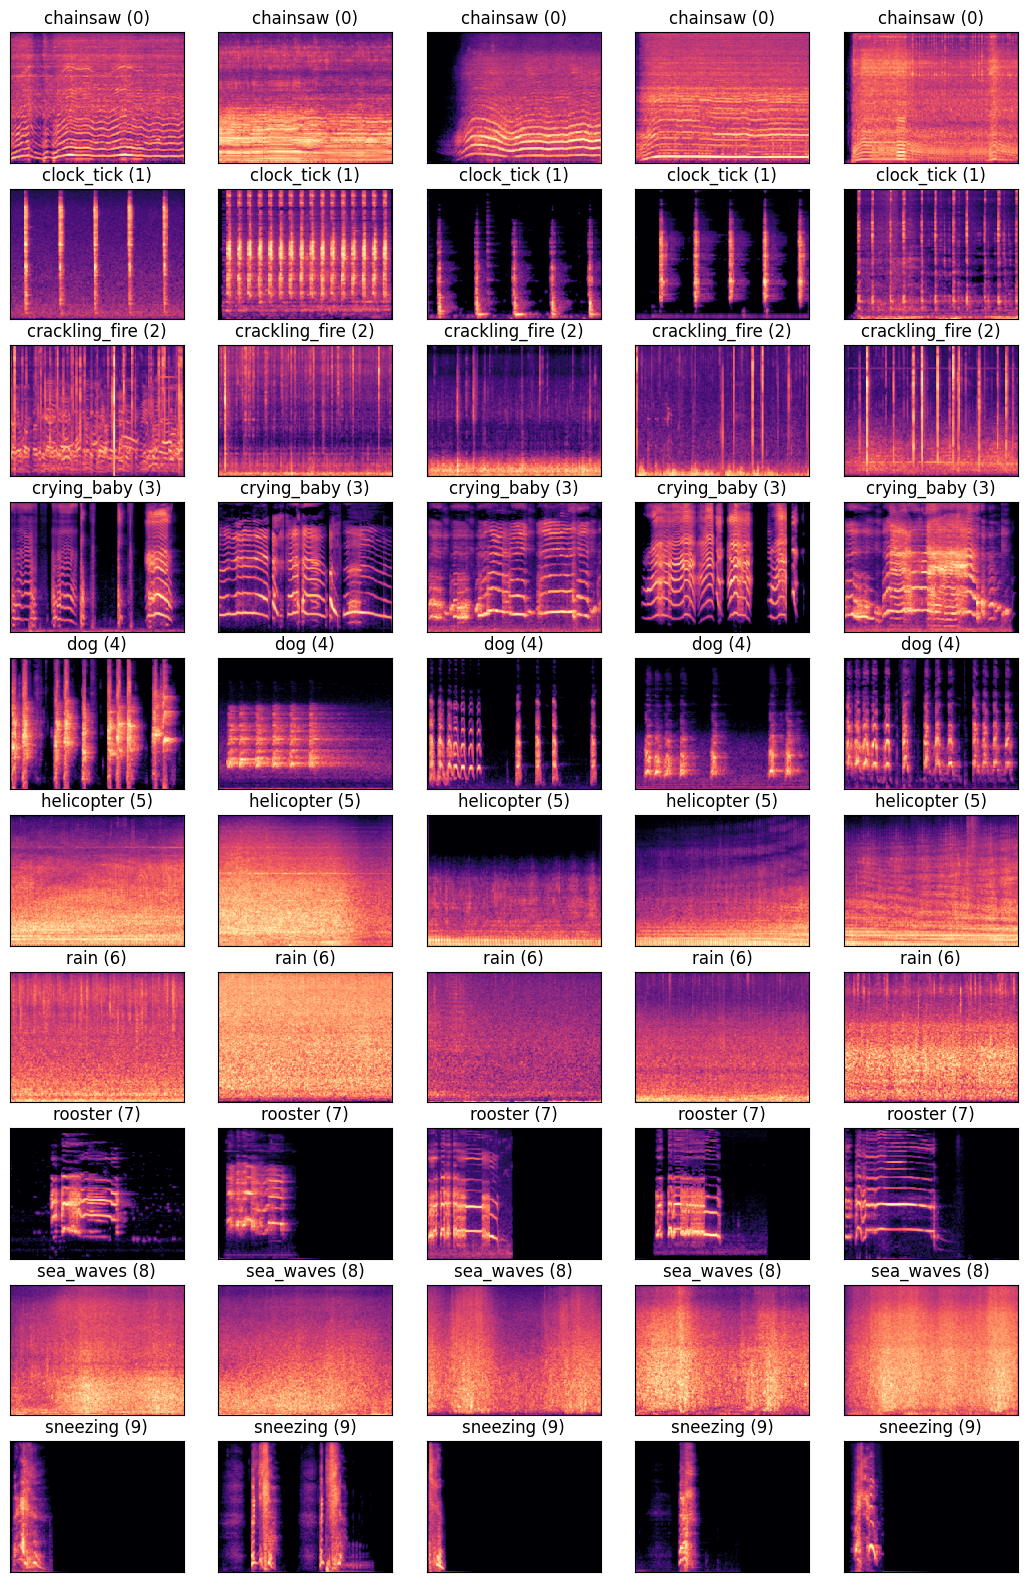

In [ ]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32

plt.show()

# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [ ]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [ ]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [ ]:
# Perceptron multi-couche
class MLP(nn.Module):
    def __init__(self, num_hidden=50, input_dim=height*width, num_targets=10):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_targets)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, height*width) # flatten le spectro
        out = self.layer1(flattened)
        out = torch.relu(out)
        out = self.layer2(out)
        return out


Compléter la fonction d'apprentissage

In [ ]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          num_epochs=10):

    # la loss
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, num_classes):
    model.eval()  # Met le modèle en mode évaluation
    true_labels = []
    predictions = []

    with torch.no_grad():  # Désactive le calcul du gradient pour économiser la mémoire et accélérer
        for imgs, labels in data_loader:
            imgs = imgs.to(device)  # Envoie les données au même appareil que le modèle
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)  # Obtient l'indice de la log-probabilité maximale
            true_labels.extend(labels.cpu().numpy())  # Stocke les étiquettes vraies
            predictions.extend(predicted.cpu().numpy())  # Stocke les prédictions

    # Calcul de la matrice de confusion
    cm = confusion_matrix(true_labels, predictions, labels=np.arange(num_classes))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalisation en pourcentage

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap='Blues', cbar=False, xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix in Percentage')
    plt.show()

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Utilise CUDA si disponible
model = MLP().to(device)
model

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


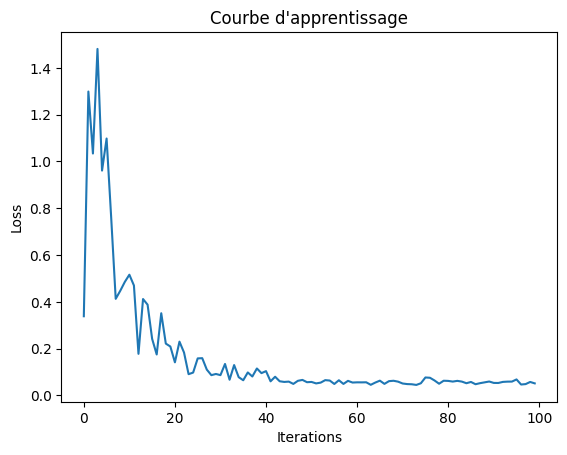

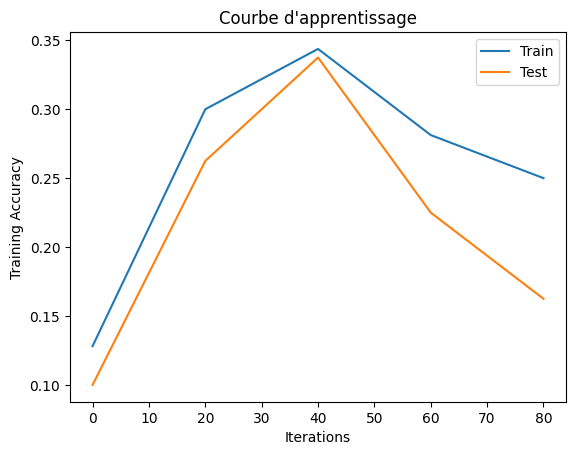

Précision finale Train : 0.25
Précision finale Test : 0.1625


In [ ]:
train(model, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=10)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN.

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement.

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes.

Une ReLU sera appliquée après chaque couche de convolution et après fc1.

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*30*52, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(-1, 32*30*52) # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Instancier le modèle CNN et afficher son nombre de paramètres

In [ ]:
model_2 = CNN()
model_2

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49920, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

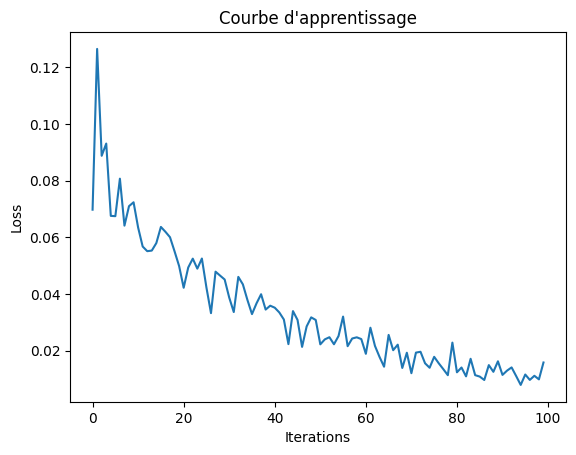

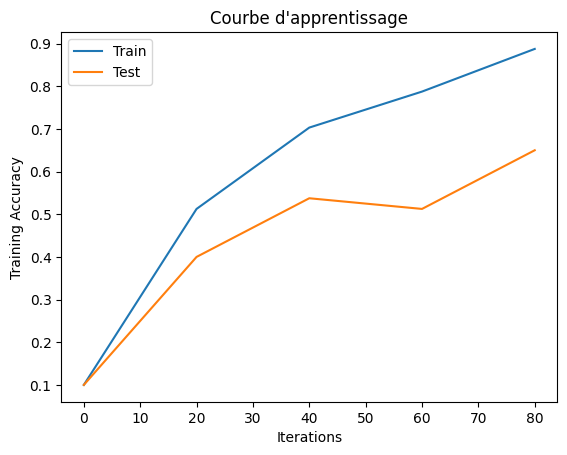

Précision finale Train : 0.8875
Précision finale Test : 0.65


In [ ]:
train(model_2, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=10)

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN.

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

In [ ]:
class ImprovedMLP(nn.Module):
    def __init__(self):
        super(ImprovedMLP, self).__init__()
        self.fc1 = nn.Linear(128*216, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.view(-1, 128*216)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Création de l'instance du modèle
Improve_model = ImprovedMLP().to(device)

# Affichage du modèle pour vérifier la structure
print(Improve_model)


ImprovedMLP(
  (fc1): Linear(in_features=27648, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def get_predictions_and_labels(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval()
    all_preds = []
    all_labels = []
    for inp, labels in data:
        output = model(inp)
        preds = output.max(1, keepdim=True)[1]  # Retrouve l'indice de la log-proba maximale
        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels


In [ ]:
pip install torchinfo


In [ ]:
from torchinfo import summary

summary(Improve_model, input_size=(1, 128*216))


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedMLP                              [1, 10]                   --
├─Linear: 1-1                            [1, 256]                  7,078,144
├─BatchNorm1d: 1-2                       [1, 256]                  512
├─LeakyReLU: 1-3                         [1, 256]                  --
├─Linear: 1-4                            [1, 128]                  32,896
├─BatchNorm1d: 1-5                       [1, 128]                  256
├─LeakyReLU: 1-6                         [1, 128]                  --
├─Linear: 1-7                            [1, 10]                   1,290
Total params: 7,113,098
Trainable params: 7,113,098
Non-trainable params: 0
Total mult-adds (M): 7.11
Input size (MB): 0.11
Forward/backward pass size (MB): 0.01
Params size (MB): 28.45
Estimated Total Size (MB): 28.57

In [ ]:
pip install skorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 3.9 MB/s eta 0:00:00


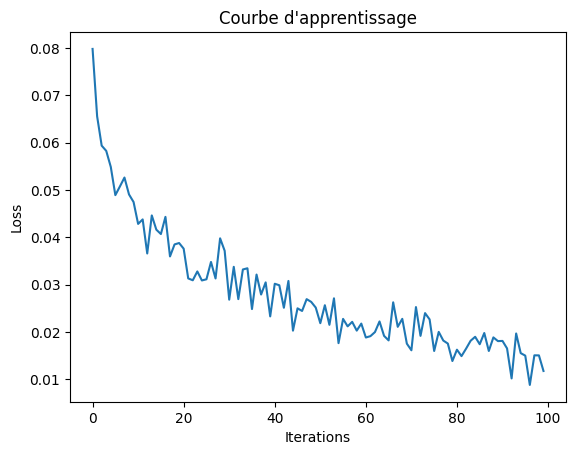

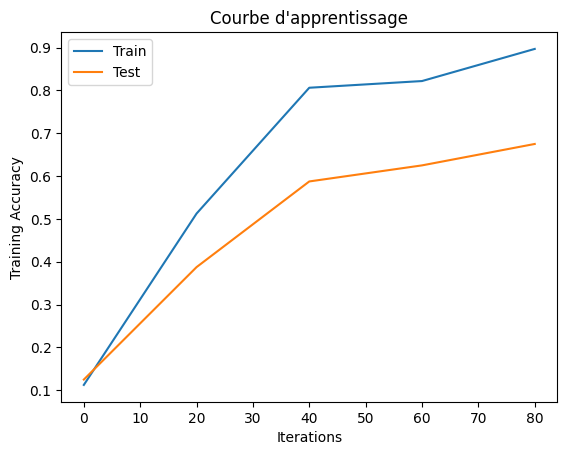

Précision finale Train : 0.896875
Précision finale Test : 0.675


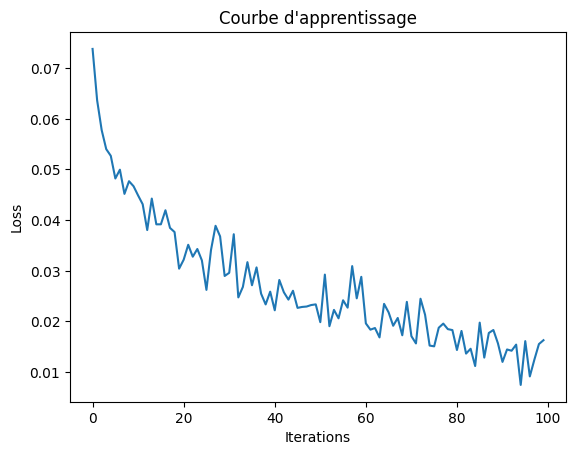

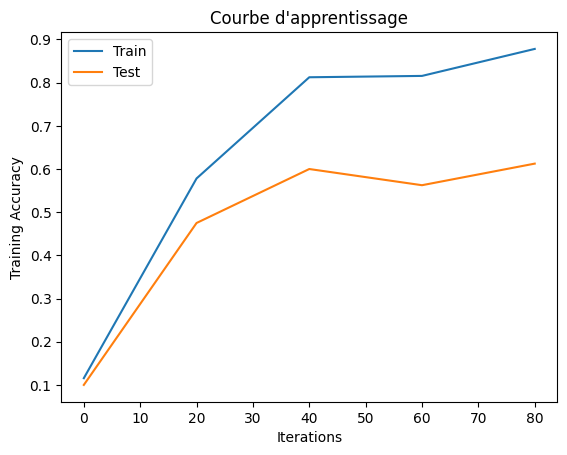

Précision finale Train : 0.878125
Précision finale Test : 0.6125


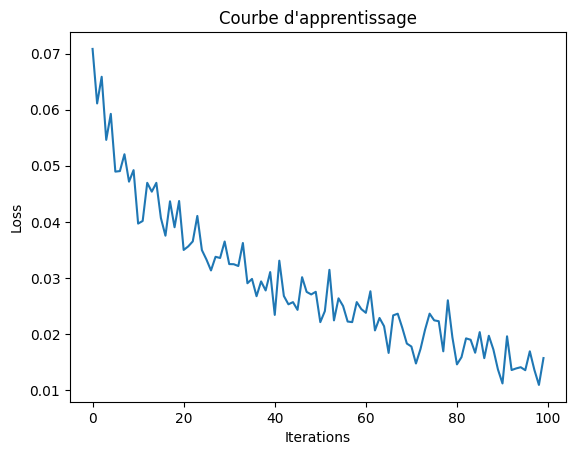

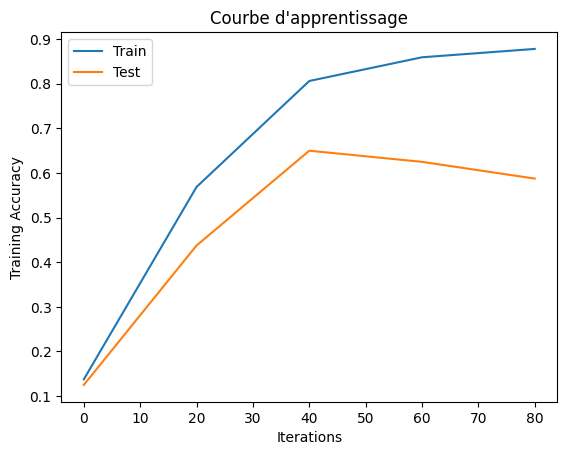

Précision finale Train : 0.878125
Précision finale Test : 0.5875


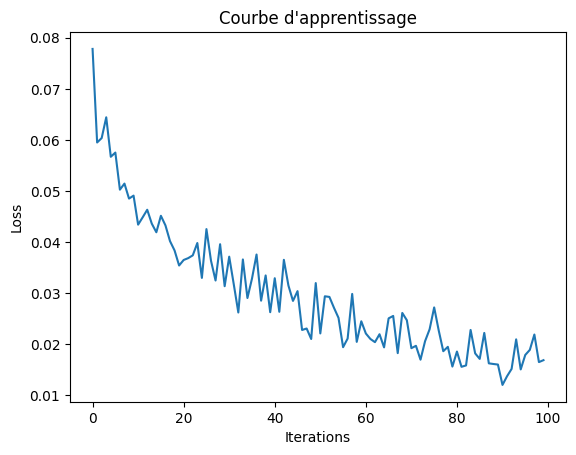

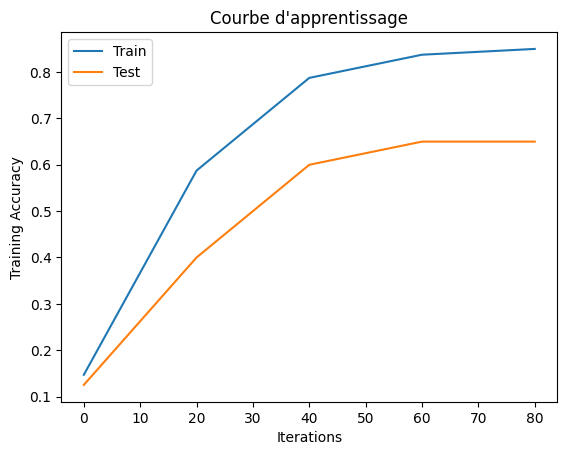

Précision finale Train : 0.85
Précision finale Test : 0.65


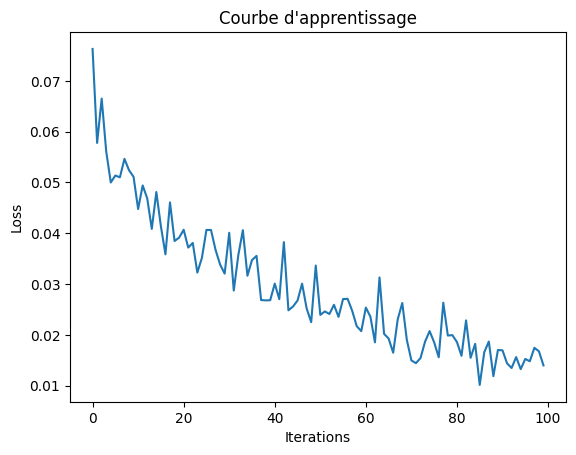

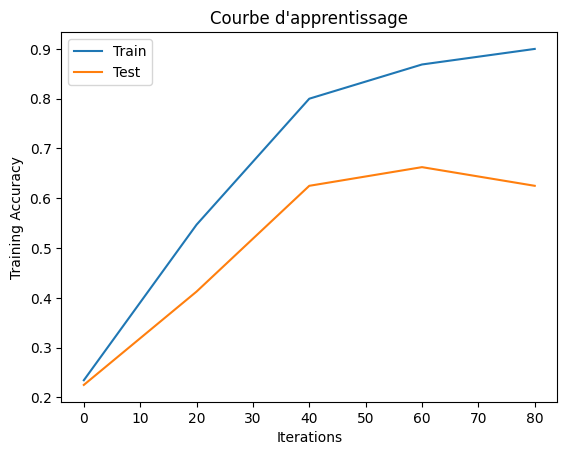

Précision finale Train : 0.9
Précision finale Test : 0.625


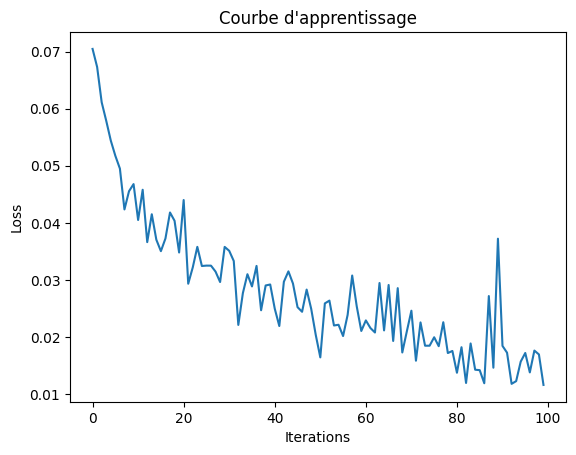

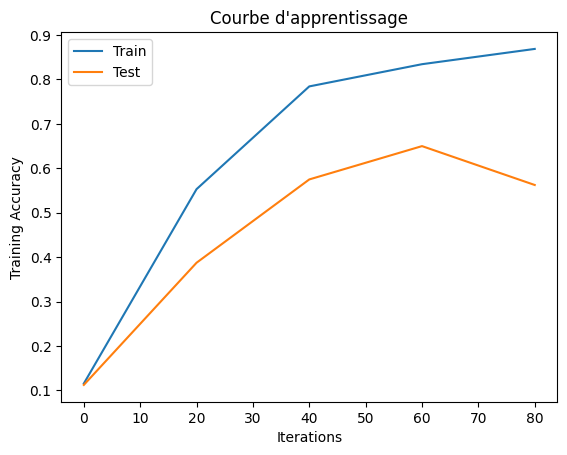

Précision finale Train : 0.86875
Précision finale Test : 0.5625


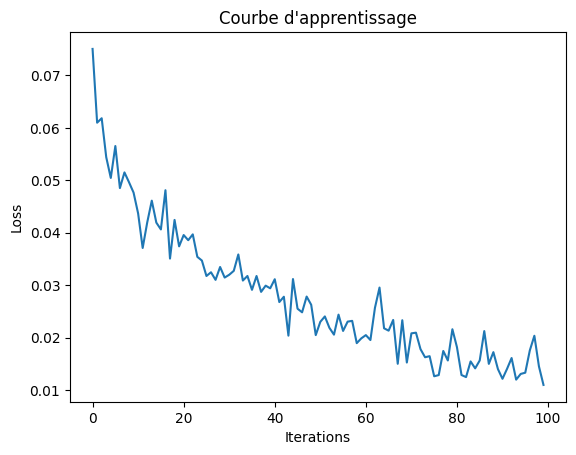

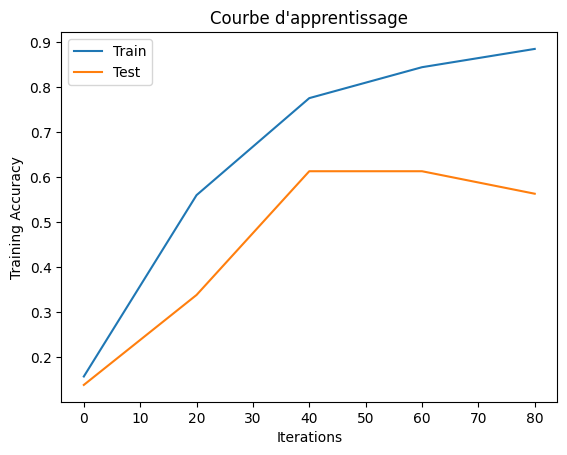

Précision finale Train : 0.884375
Précision finale Test : 0.5625


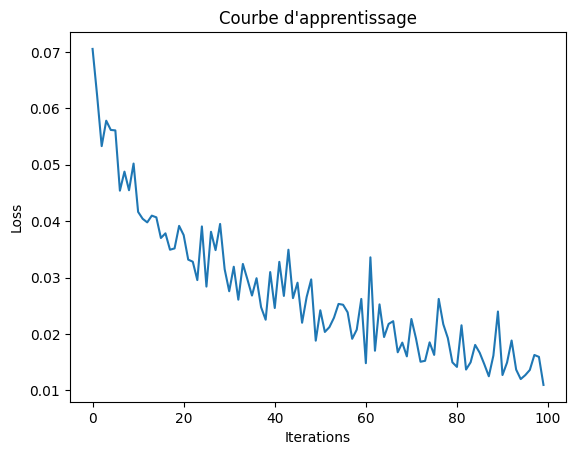

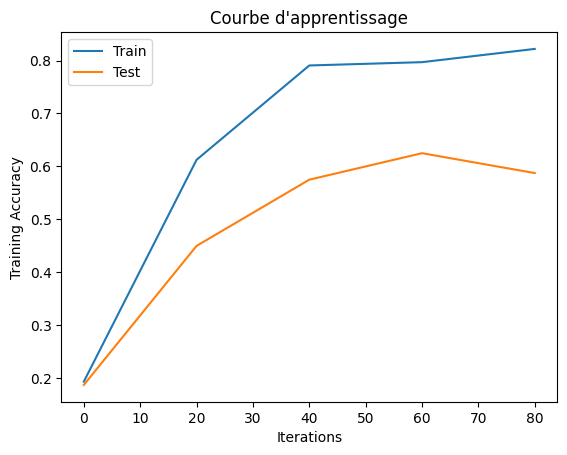

Précision finale Train : 0.821875
Précision finale Test : 0.5875


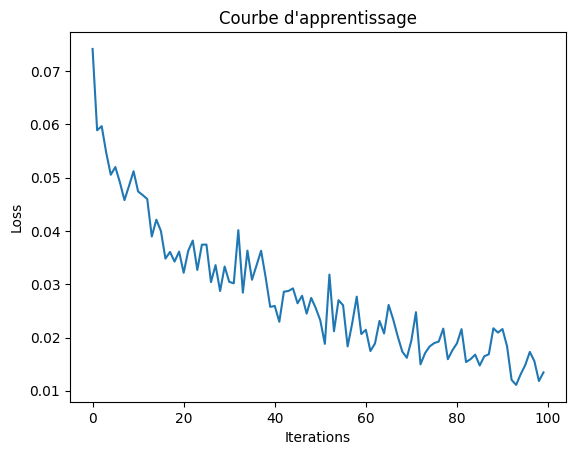

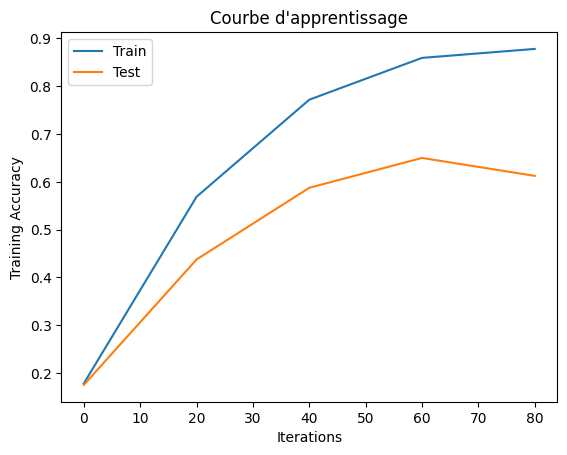

Précision finale Train : 0.878125
Précision finale Test : 0.6125


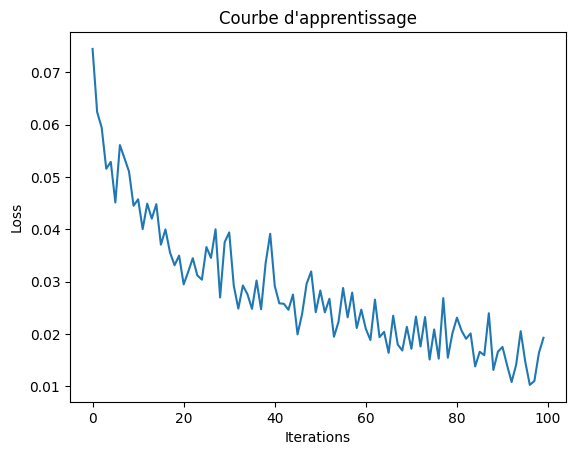

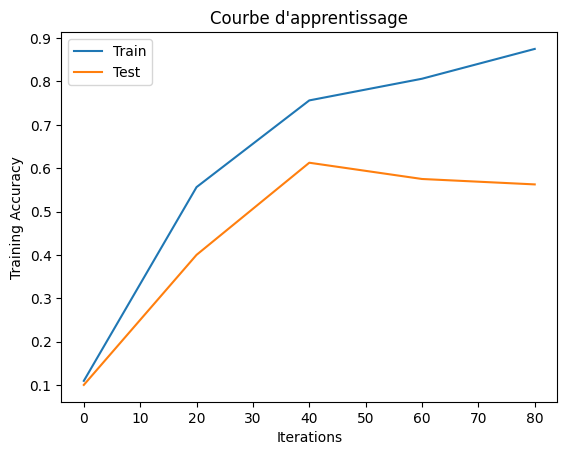

Précision finale Train : 0.875
Précision finale Test : 0.5625


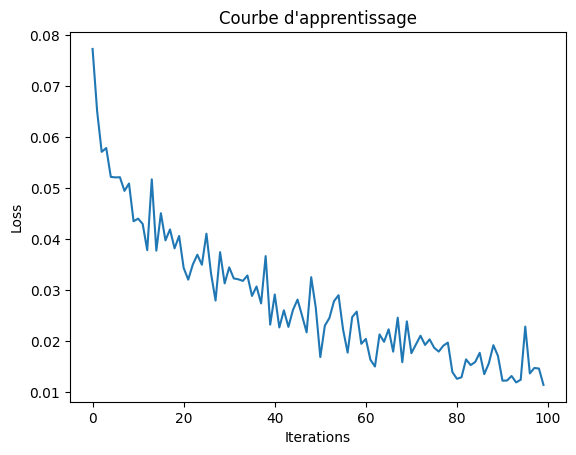

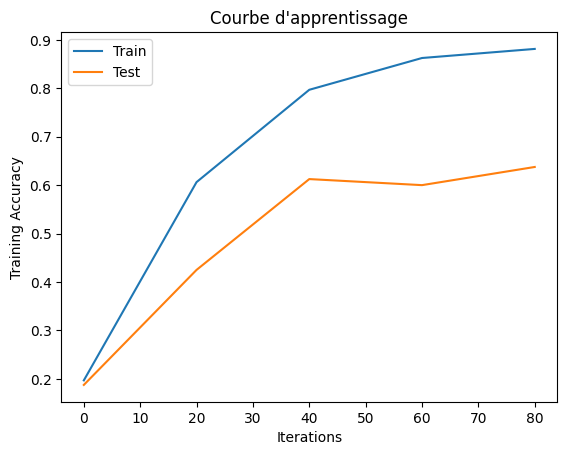

Précision finale Train : 0.88125
Précision finale Test : 0.6375


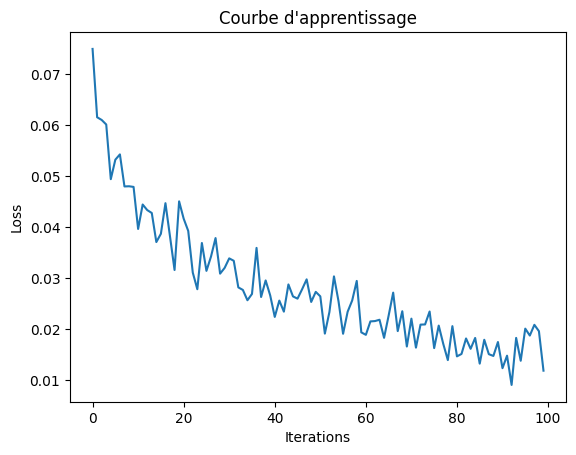

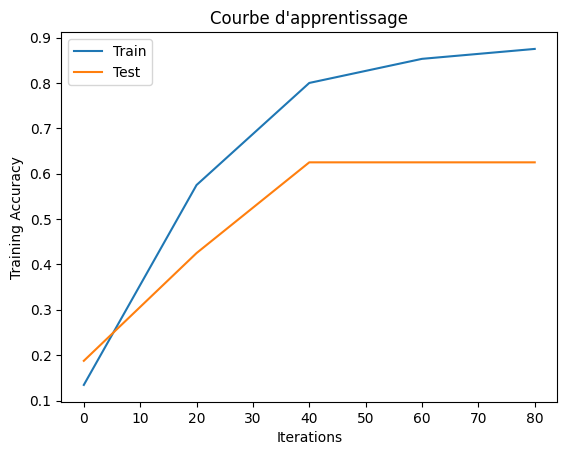

Précision finale Train : 0.875
Précision finale Test : 0.625


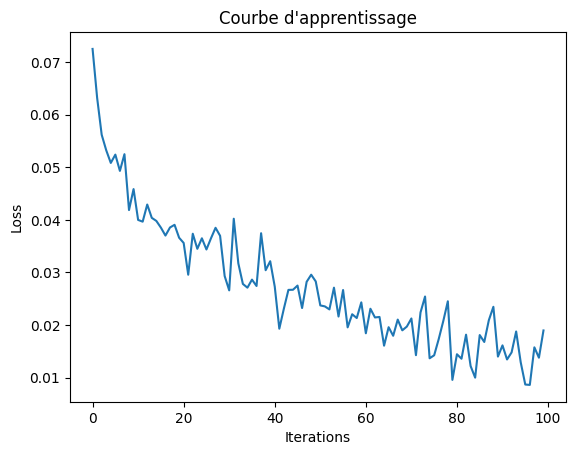

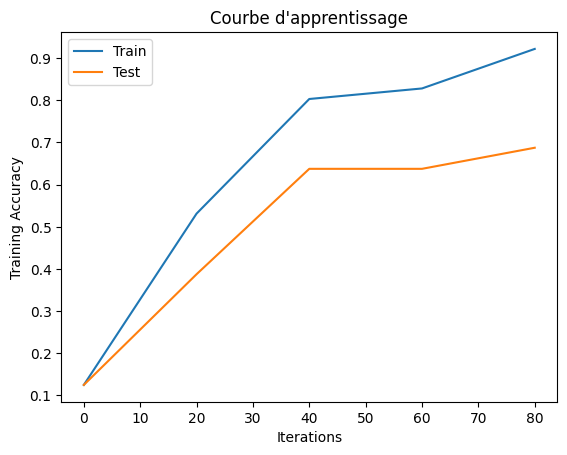

Précision finale Train : 0.921875
Précision finale Test : 0.6875


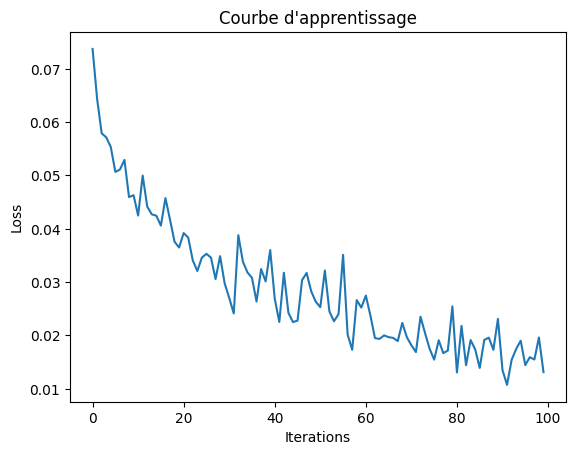

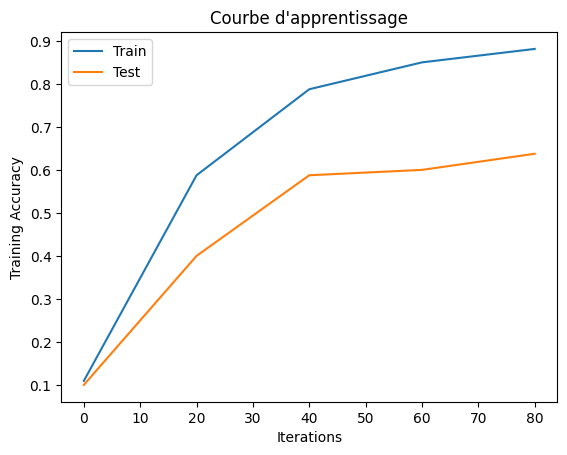

Précision finale Train : 0.88125
Précision finale Test : 0.6375


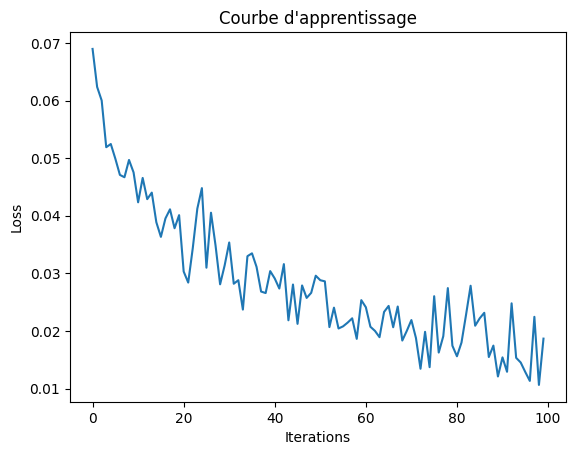

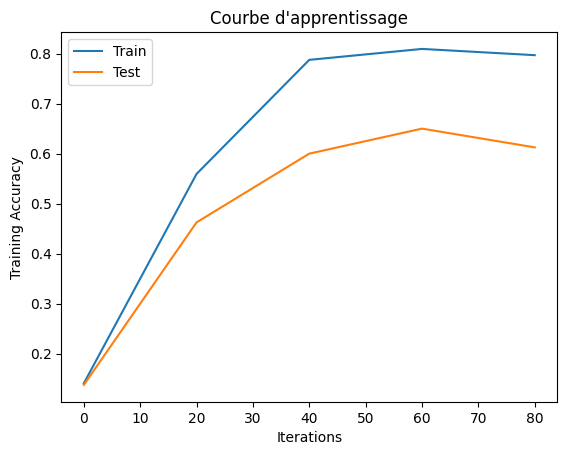

Précision finale Train : 0.796875
Précision finale Test : 0.6125


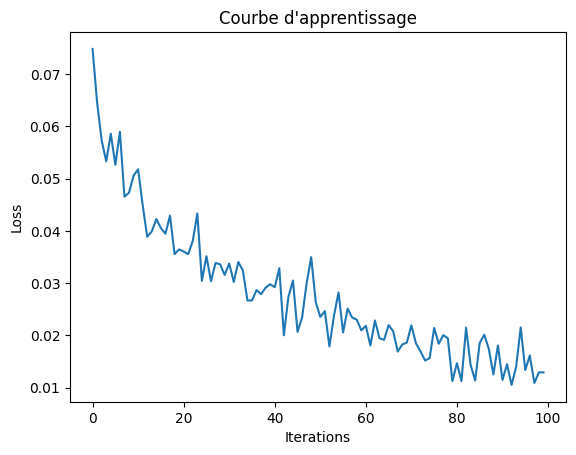

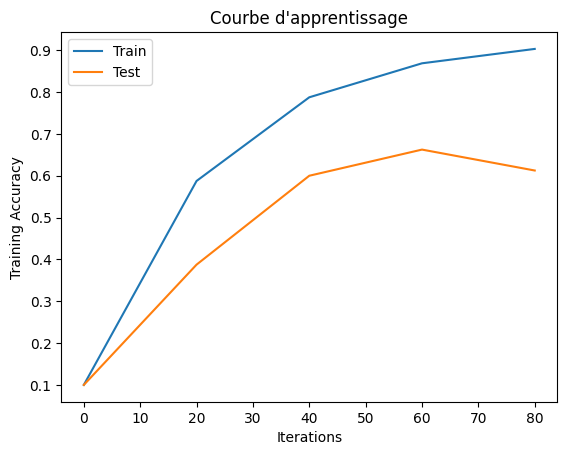

Précision finale Train : 0.903125
Précision finale Test : 0.6125


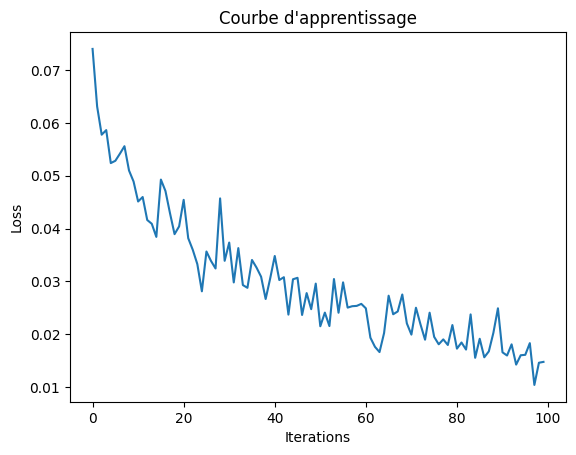

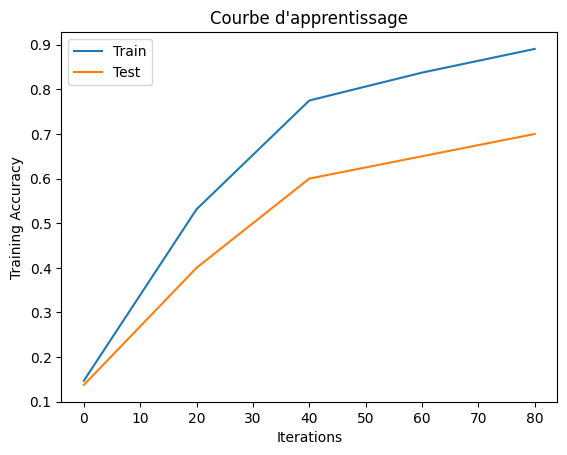

Précision finale Train : 0.890625
Précision finale Test : 0.7


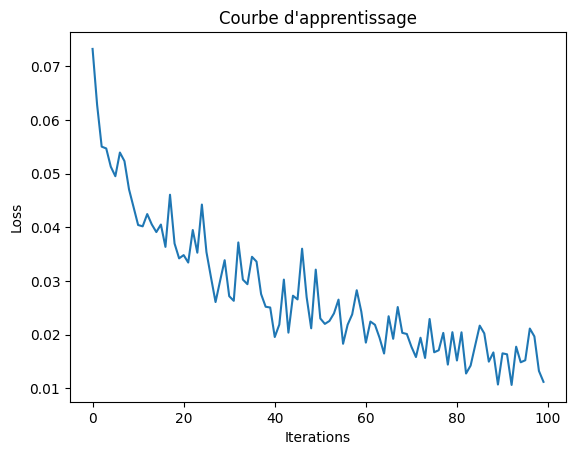

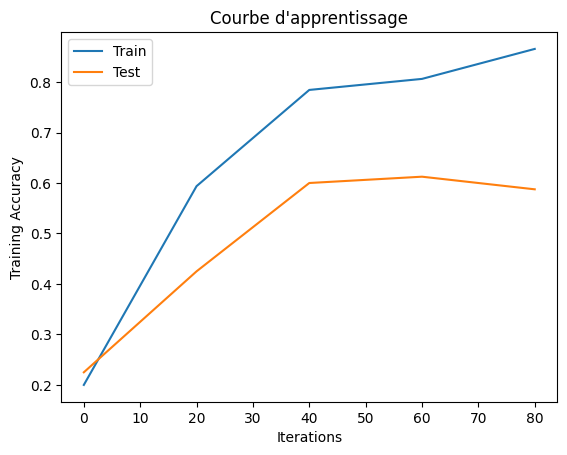

Précision finale Train : 0.865625
Précision finale Test : 0.5875


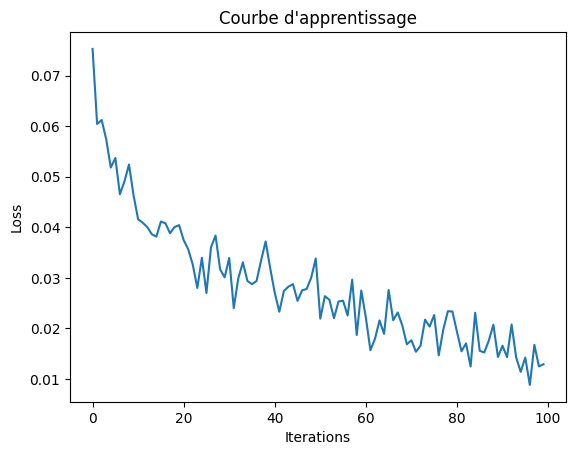

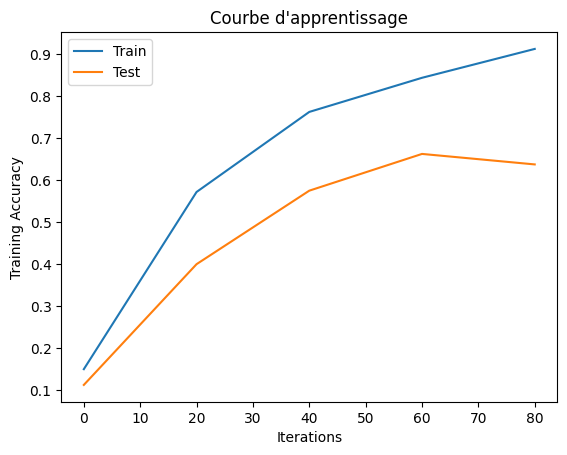

Précision finale Train : 0.9125
Précision finale Test : 0.6375


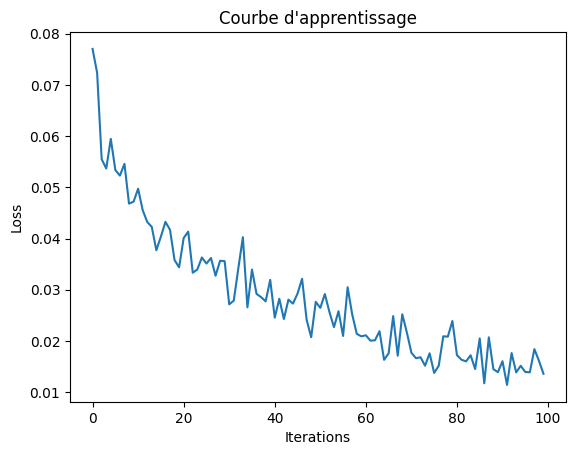

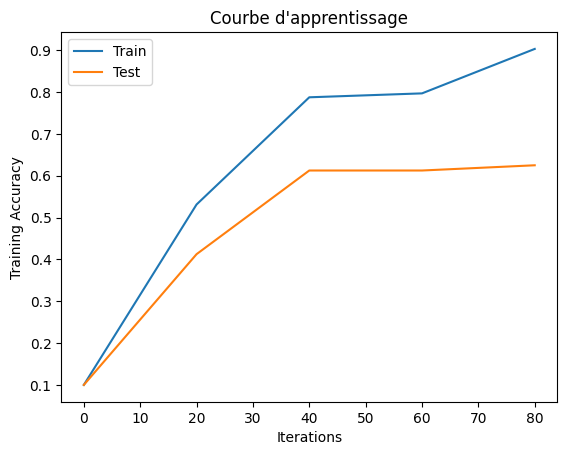

Précision finale Train : 0.903125
Précision finale Test : 0.625
Average Test Accuracy after 20 runs: 0.63


0.626875

In [ ]:
def evaluate_multiple_times(model, num_trials=20, batch_size=32, learning_rate=0.001, num_epochs=10, optimizer_type="adam"):
    test_accuracies = []
    for _ in range(num_trials):
        # Réinitialiser le modèle à chaque fois pour l'entraînement indépendant
        model = ImprovedMLP().to(device)
        train(model, batch_size=batch_size, optimizer=optimizer_type, learning_rate=learning_rate, num_epochs=num_epochs)
        test_acc = get_accuracy(model, train=False)  # Assure-toi que cette fonction utilise le bon DataLoader
        test_accuracies.append(test_acc)

    average_accuracy = sum(test_accuracies) / len(test_accuracies)
    print(f"Average Test Accuracy after {num_trials} runs: {average_accuracy:.2f}")
    return average_accuracy

# Appel de la fonction
evaluate_multiple_times(ImprovedMLP)


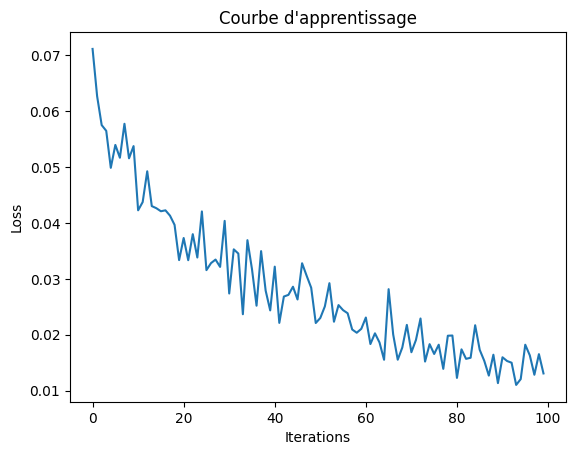

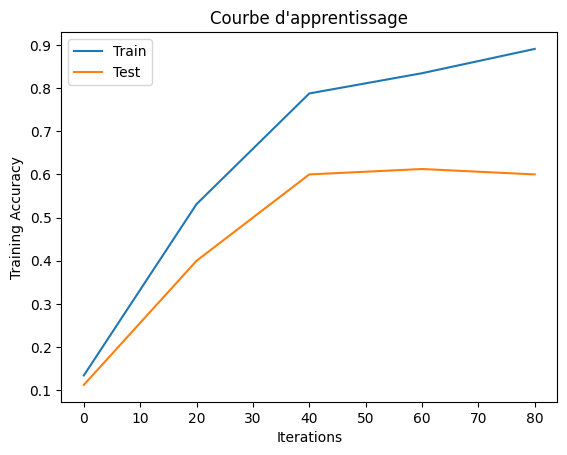

Précision finale Train : 0.890625
Précision finale Test : 0.6
Learning Rate: 0.001, Num Epochs: 10, Test Accuracy: 0.59


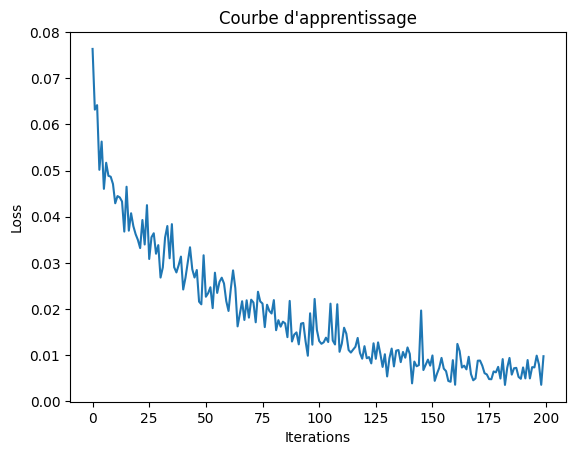

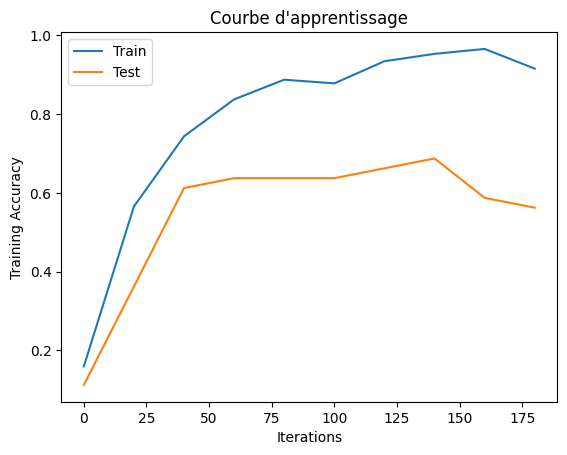

Précision finale Train : 0.915625
Précision finale Test : 0.5625
Learning Rate: 0.001, Num Epochs: 20, Test Accuracy: 0.46


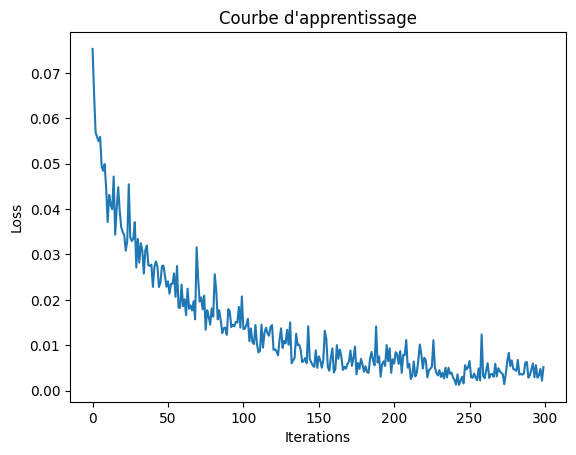

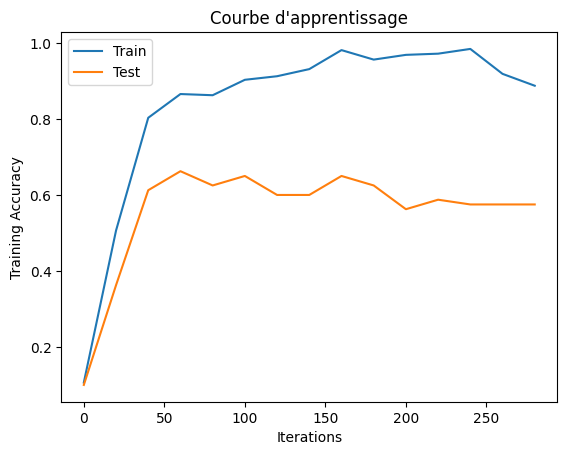

Précision finale Train : 0.8875
Précision finale Test : 0.575
Learning Rate: 0.001, Num Epochs: 30, Test Accuracy: 0.62


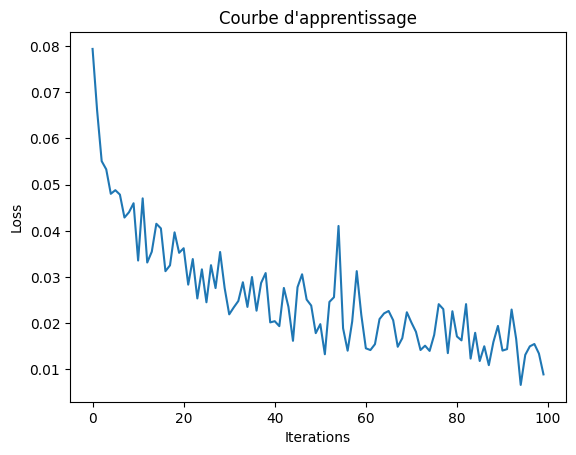

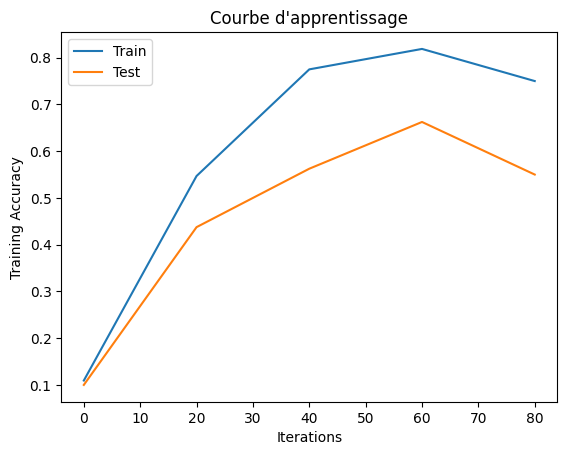

Précision finale Train : 0.75
Précision finale Test : 0.55
Learning Rate: 0.01, Num Epochs: 10, Test Accuracy: 0.60


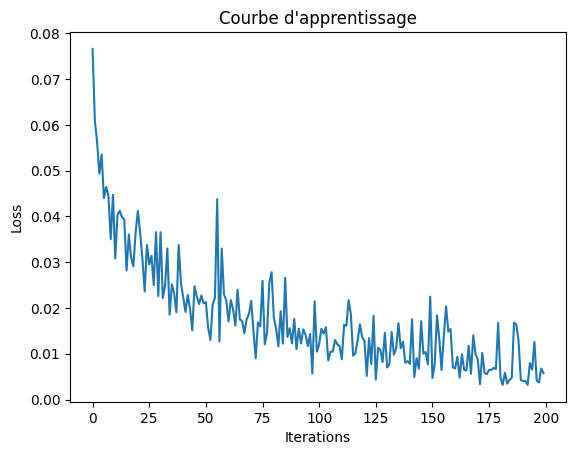

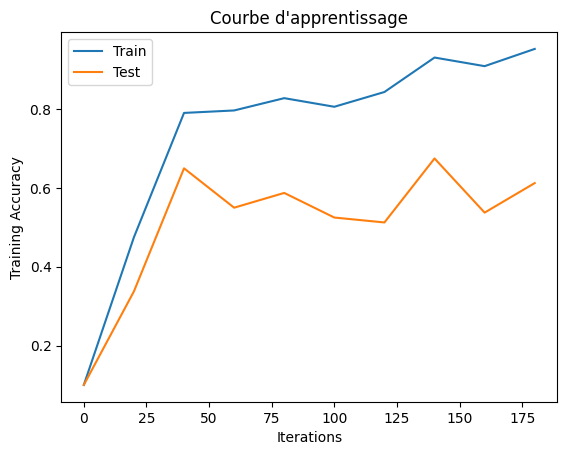

Précision finale Train : 0.953125
Précision finale Test : 0.6125
Learning Rate: 0.01, Num Epochs: 20, Test Accuracy: 0.56


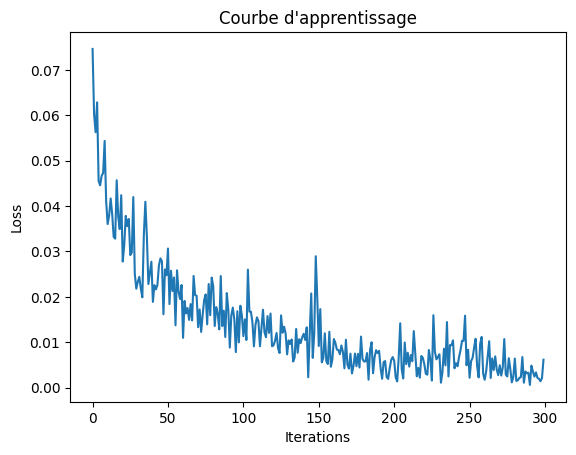

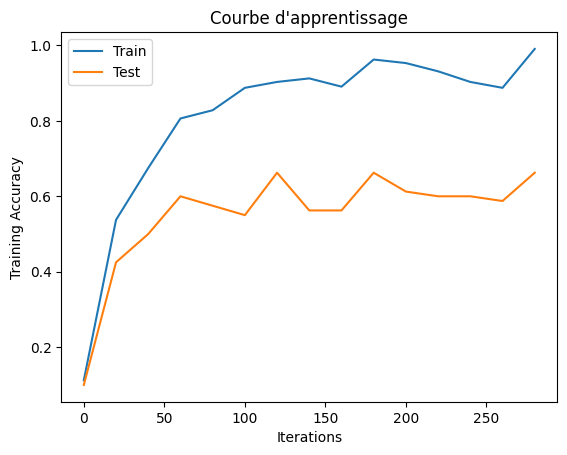

Précision finale Train : 0.990625
Précision finale Test : 0.6625
Learning Rate: 0.01, Num Epochs: 30, Test Accuracy: 0.50


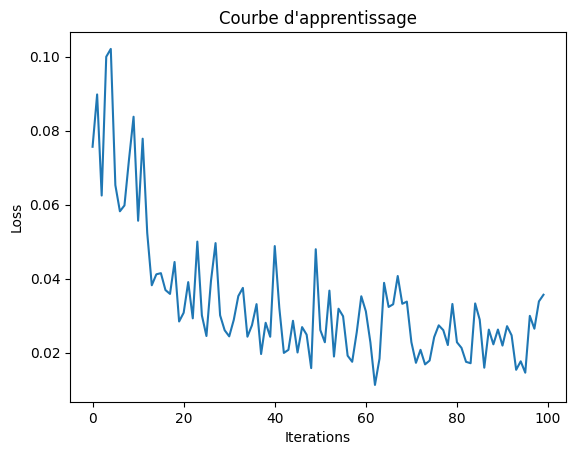

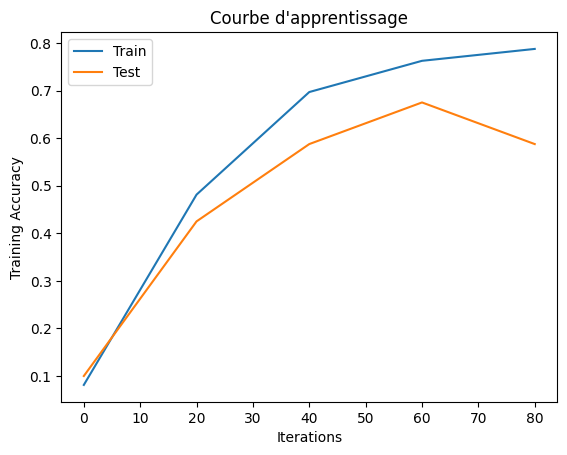

Précision finale Train : 0.7875
Précision finale Test : 0.5875
Learning Rate: 0.1, Num Epochs: 10, Test Accuracy: 0.50


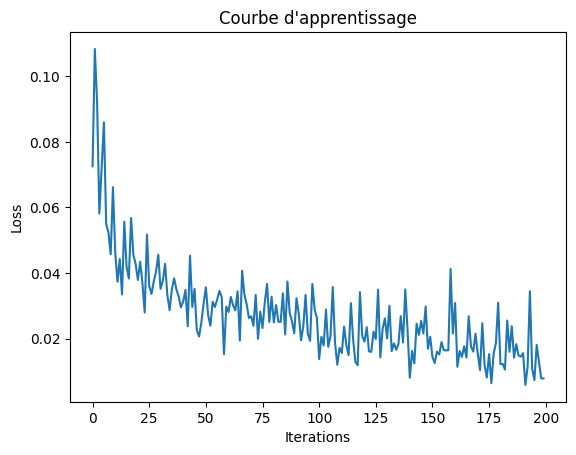

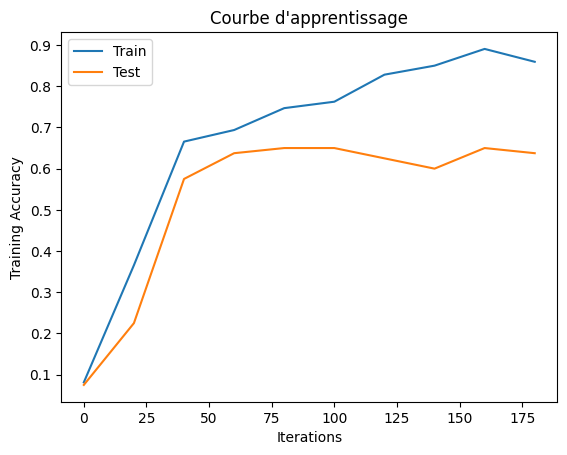

Précision finale Train : 0.859375
Précision finale Test : 0.6375
Learning Rate: 0.1, Num Epochs: 20, Test Accuracy: 0.53


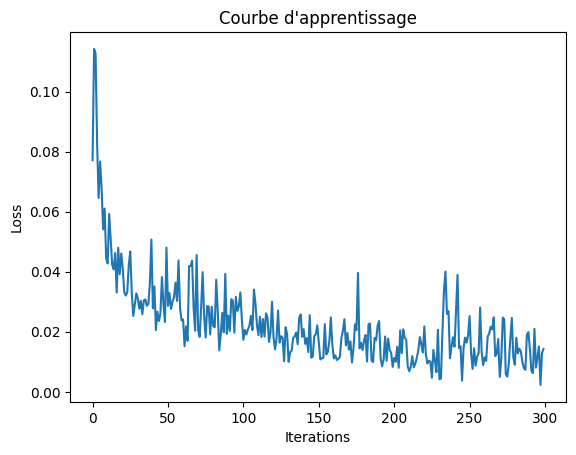

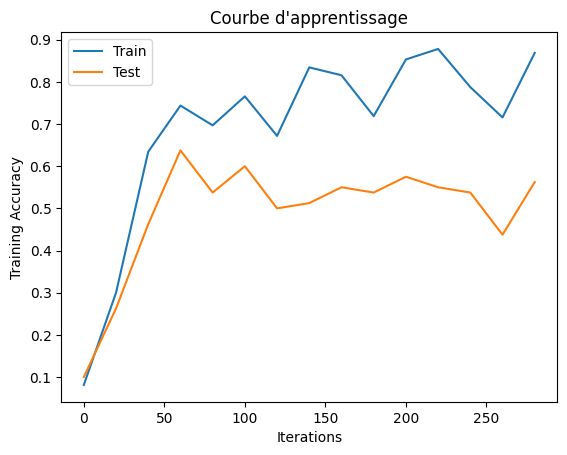

Précision finale Train : 0.86875
Précision finale Test : 0.5625
Learning Rate: 0.1, Num Epochs: 30, Test Accuracy: 0.57
Best model achieved an accuracy of 0.62


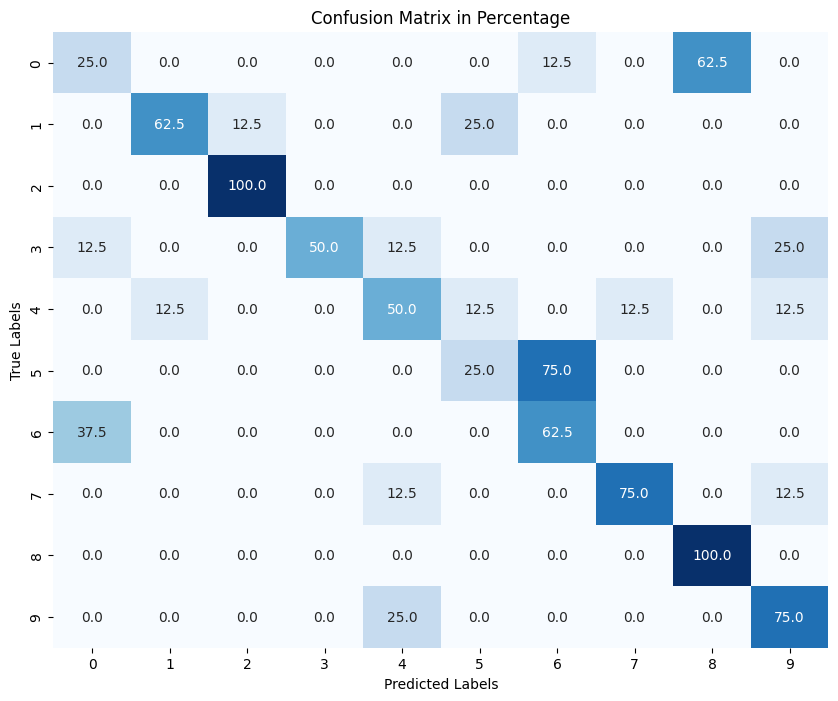

In [ ]:
def hyperparameter_testing(model_class, learning_rates, num_epochs_list, batch_size=32):
    best_accuracy = 0
    best_model = None
    results = []
    for lr in learning_rates:
        for epochs in num_epochs_list:
            model = model_class().to(device)  # Réinitialisation et transfert du modèle sur le bon appareil
            train(model, batch_size=batch_size, optimizer="adam", learning_rate=lr, num_epochs=epochs)
            test_acc = get_accuracy(model, train=False)  # Utilisation directe de la précision retournée
            results.append((lr, epochs, test_acc))
            print(f"Learning Rate: {lr}, Num Epochs: {epochs}, Test Accuracy: {test_acc:.2f}")
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_model = model  # Sauvegarde du meilleur modèle

    return results, best_model, best_accuracy  # Retourne également la meilleure précision pour référence

# Utilisation de la fonction et affichage des résultats
hyper_results, best_model, best_accuracy = hyperparameter_testing(ImprovedMLP, [0.001, 0.01, 0.1], [10, 20, 30], batch_size=32)
print(f"Best model achieved an accuracy of {best_accuracy:.2f}")

# Affichage de la matrice de confusion pour le meilleur modèle
plot_confusion_matrix(best_model, test_loader, num_classes=10)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


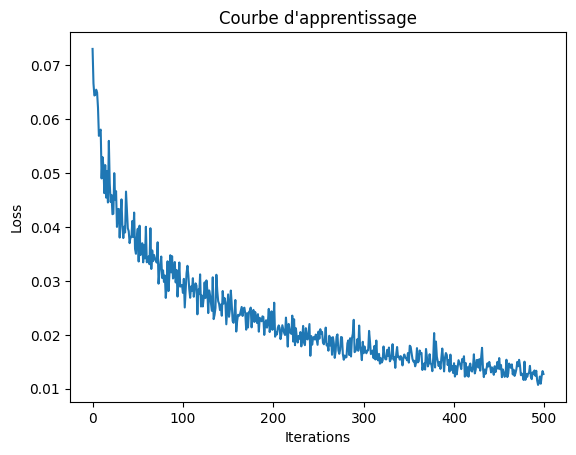

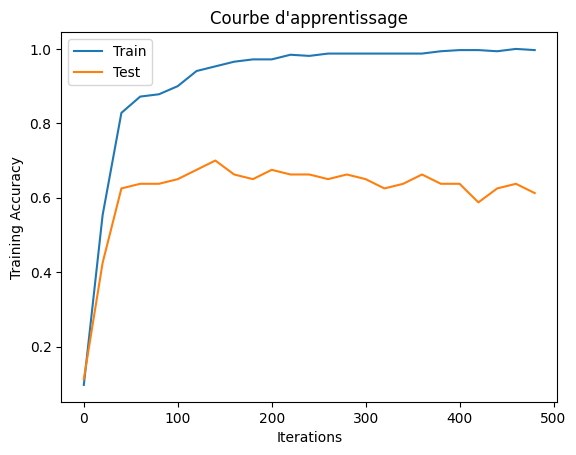

Précision finale Train : 0.996875
Précision finale Test : 0.6125


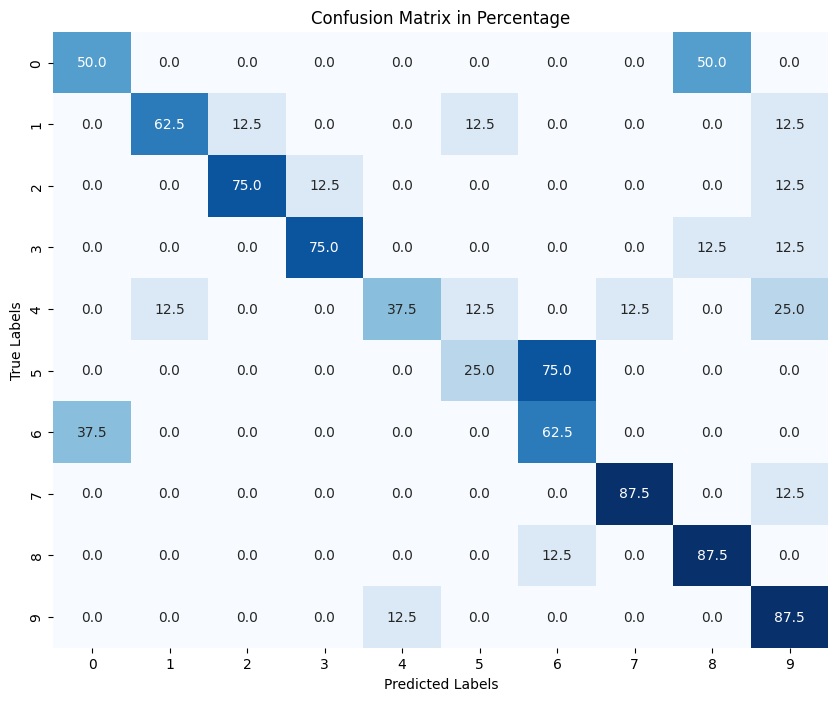

In [ ]:
# Entraînement avec un taux très bas pour Adam
train(Improve_model, batch_size=32, optimizer="adam", learning_rate=0.00001, num_epochs=50)
plot_confusion_matrix(Improve_model, test_loader, num_classes=10)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


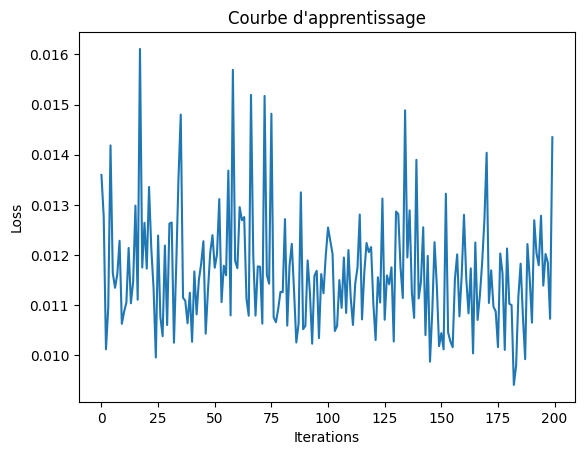

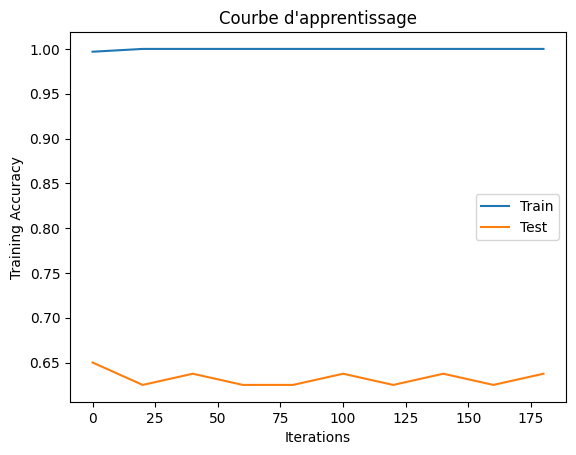

Précision finale Train : 1.0
Précision finale Test : 0.6375


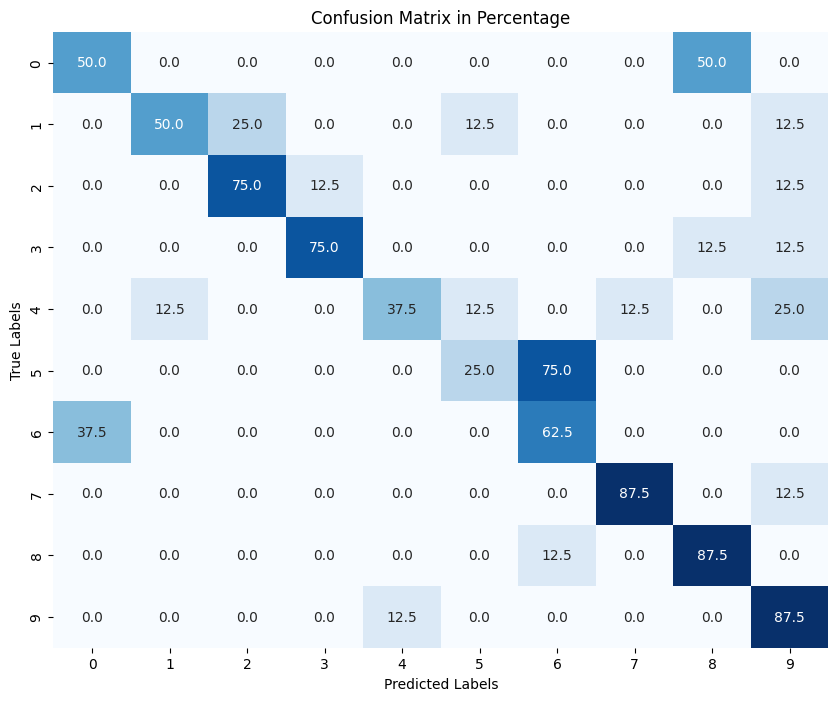

In [ ]:
train(Improve_model, batch_size=32, optimizer="sgd", learning_rate=0.00001, num_epochs=20)
plot_confusion_matrix(Improve_model, test_loader, num_classes=10)

In [ ]:
class ModifiedCNN(nn.Module):
    def __init__(self):
        super( ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*30*52, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64*30*52) # flatten
        x = self.dropout(torch.relu(self.bn4(self.fc1(x))))
        x = self.fc2(x)

        return x


In [ ]:
ModifiedCNN_model = ModifiedCNN().to(device)
ModifiedCNN_model

ModifiedCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=99840, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
summary(ModifiedCNN_model, input_size=(1, 1, 128, 216))

Layer (type:depth-idx)                   Output Shape              Param #
ModifiedCNN                              [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 126, 214]         160
├─BatchNorm2d: 1-2                       [1, 16, 126, 214]         32
├─Conv2d: 1-3                            [1, 32, 124, 212]         4,640
├─BatchNorm2d: 1-4                       [1, 32, 124, 212]         64
├─MaxPool2d: 1-5                         [1, 32, 62, 106]          --
├─Conv2d: 1-6                            [1, 64, 60, 104]          18,496
├─BatchNorm2d: 1-7                       [1, 64, 60, 104]          128
├─MaxPool2d: 1-8                         [1, 64, 30, 52]           --
├─Linear: 1-9                            [1, 256]                  25,559,296
├─BatchNorm1d: 1-10                      [1, 256]                  512
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 10]                   

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


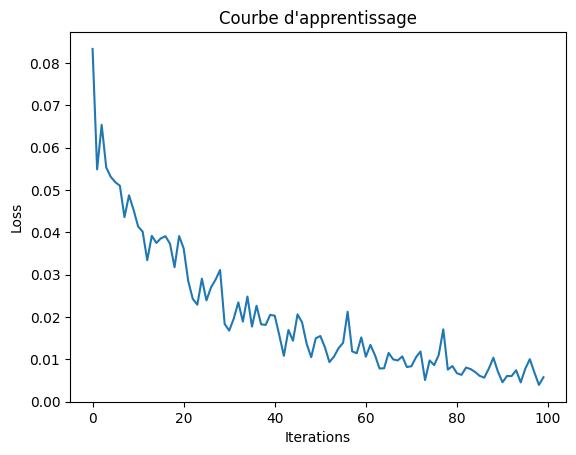

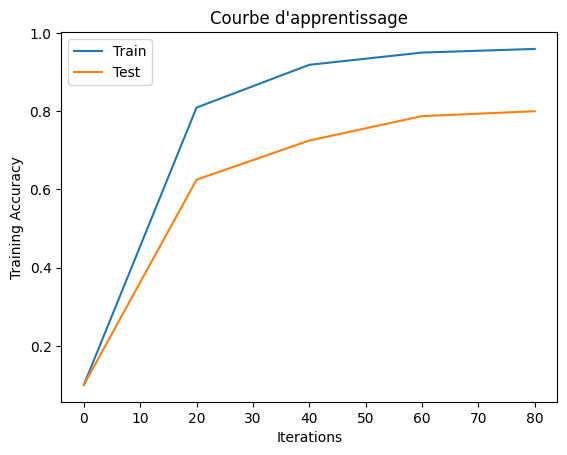

Précision finale Train : 0.959375
Précision finale Test : 0.8
Learning Rate: 0.001, Num Epochs: 10, Test Accuracy: 0.79


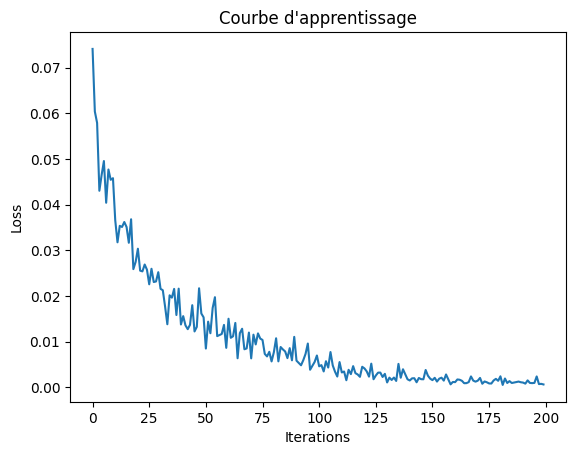

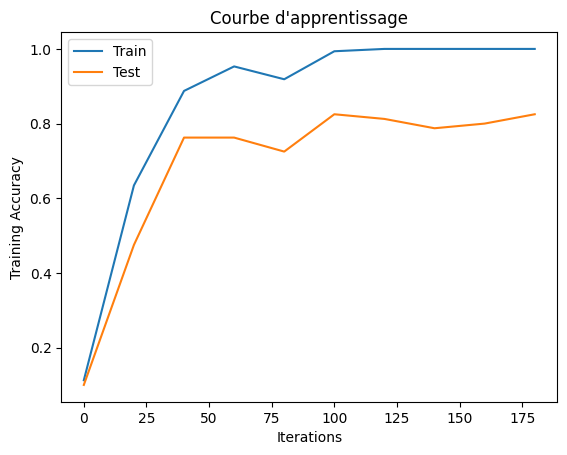

Précision finale Train : 1.0
Précision finale Test : 0.825
Learning Rate: 0.001, Num Epochs: 20, Test Accuracy: 0.84


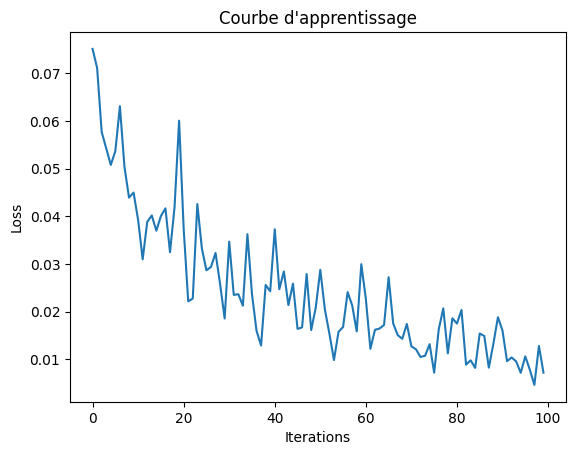

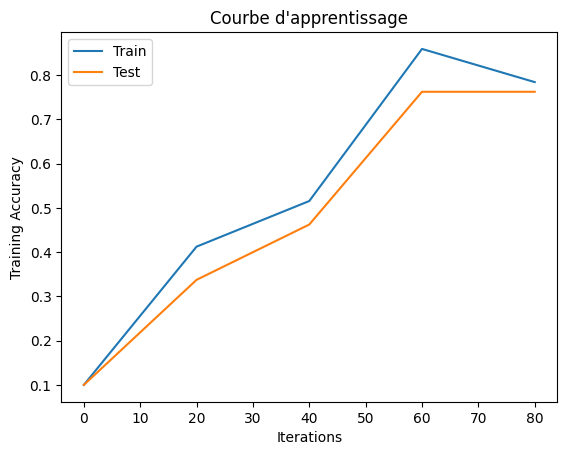

Précision finale Train : 0.784375
Précision finale Test : 0.7625
Learning Rate: 0.01, Num Epochs: 10, Test Accuracy: 0.54


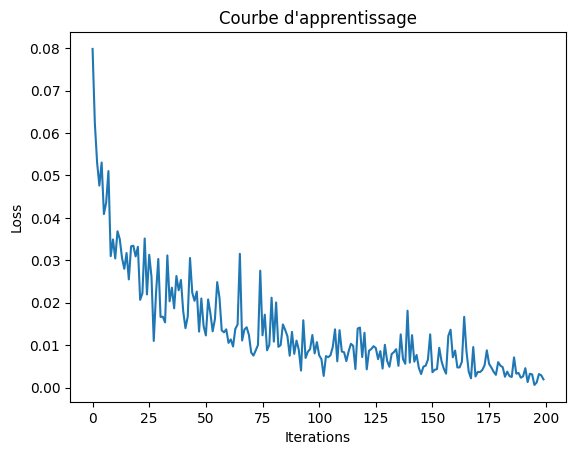

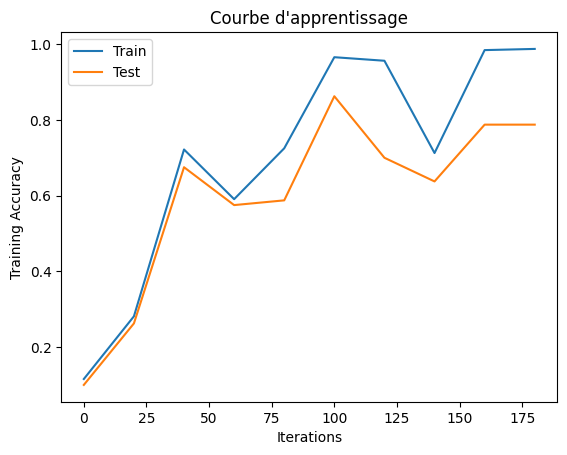

Précision finale Train : 0.9875
Précision finale Test : 0.7875
Learning Rate: 0.01, Num Epochs: 20, Test Accuracy: 0.81


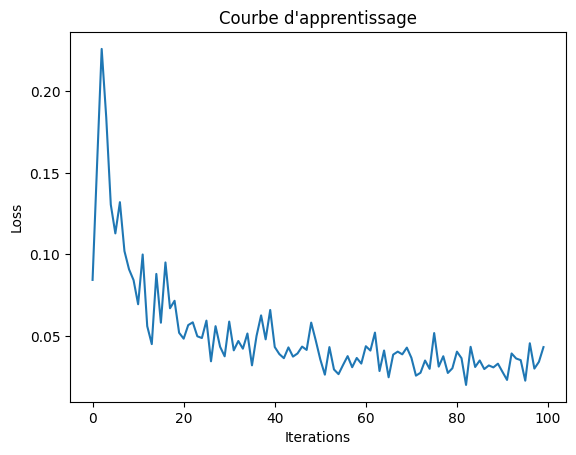

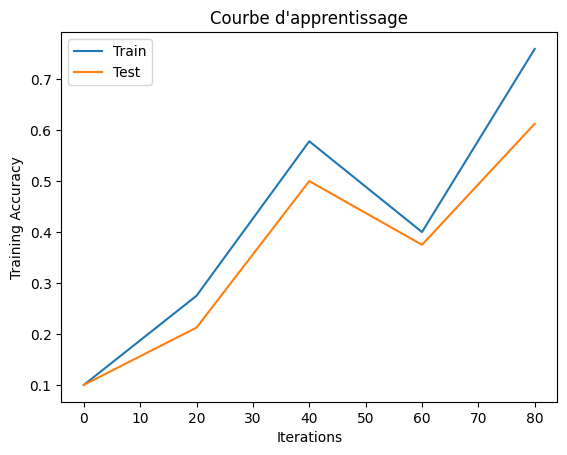

Précision finale Train : 0.759375
Précision finale Test : 0.6125
Learning Rate: 0.1, Num Epochs: 10, Test Accuracy: 0.61


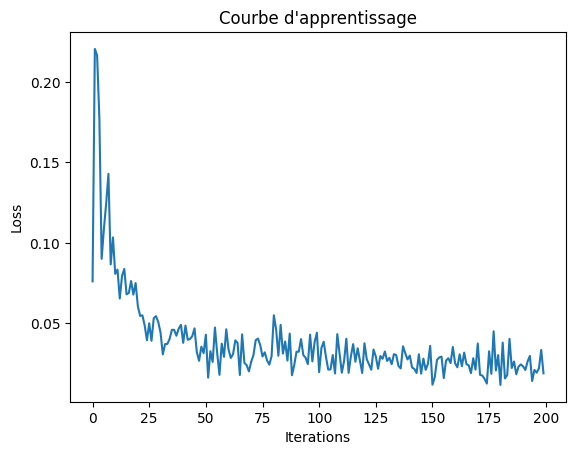

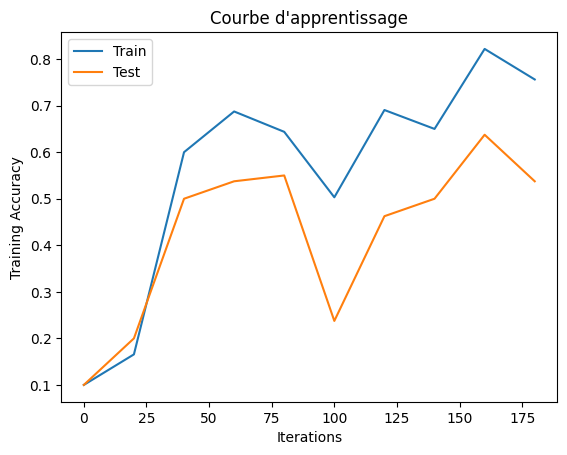

Précision finale Train : 0.75625
Précision finale Test : 0.5375
Learning Rate: 0.1, Num Epochs: 20, Test Accuracy: 0.65
Best CNN model achieved an accuracy of 0.84


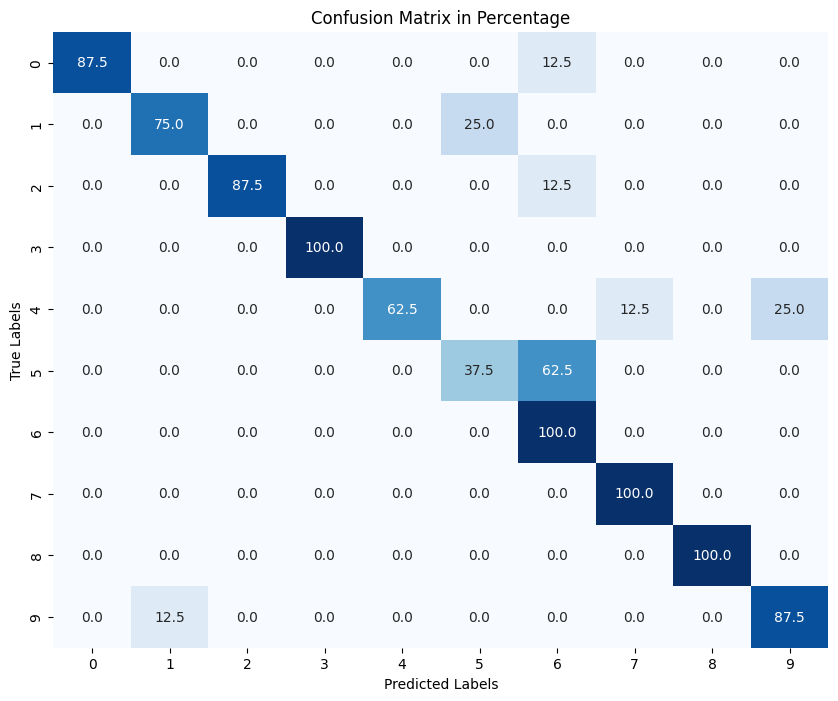

In [ ]:
def hyperparameter_testing_CNN(model_class, learning_rates, num_epochs_list, batch_size=32):
    best_accuracy = 0
    best_model = None
    results = []
    for lr in learning_rates:
        for epochs in num_epochs_list:
            model = model_class().to(device)  # Assurez-vous que votre classe CNN est compatible avec .to(device)
            train(model, batch_size=batch_size, optimizer="adam", learning_rate=lr, num_epochs=epochs)
            test_acc = get_accuracy(model, train=False)
            results.append((lr, epochs, test_acc))
            print(f"Learning Rate: {lr}, Num Epochs: {epochs}, Test Accuracy: {test_acc:.2f}")
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_model = model  # Stocke le meilleur modèle basé sur la précision de test

    return results, best_model, best_accuracy

# Exemple d'utilisation pour CNN
hyper_results, best_model_cnn, best_accuracy_cnn = hyperparameter_testing_CNN(ModifiedCNN, [0.001, 0.01, 0.1], [10, 20], batch_size=32)
print(f"Best CNN model achieved an accuracy of {best_accuracy_cnn:.2f}")

# Affichage de la matrice de confusion pour le meilleur modèle CNN
plot_confusion_matrix(best_model_cnn, test_loader, num_classes=10)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


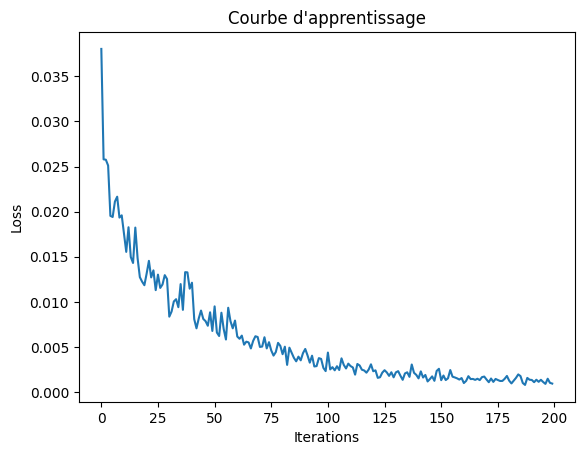

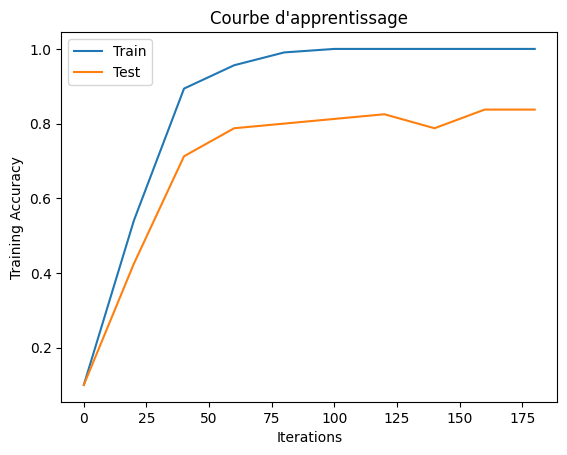

Précision finale Train : 1.0
Précision finale Test : 0.8375


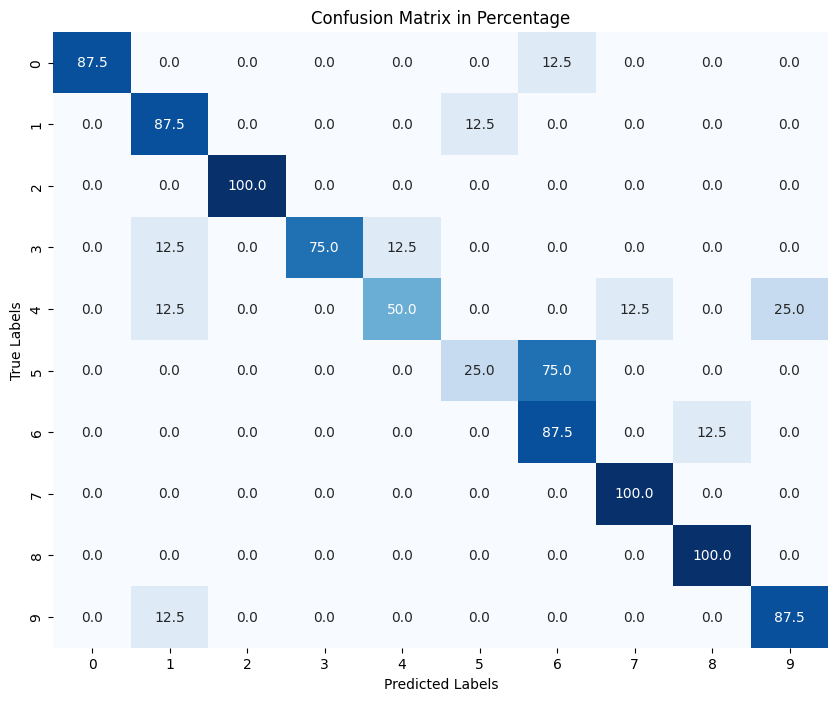

In [ ]:
train(ModifiedCNN_model, batch_size=64, optimizer="adam", learning_rate=0.0001, num_epochs=20)
plot_confusion_matrix(ModifiedCNN_model, test_loader, num_classes=10)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


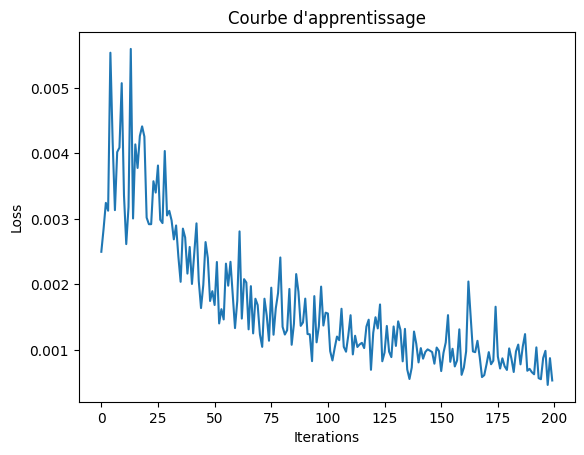

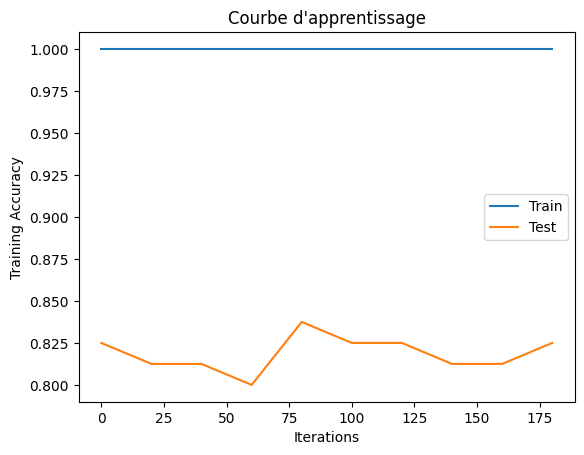

Précision finale Train : 1.0
Précision finale Test : 0.825


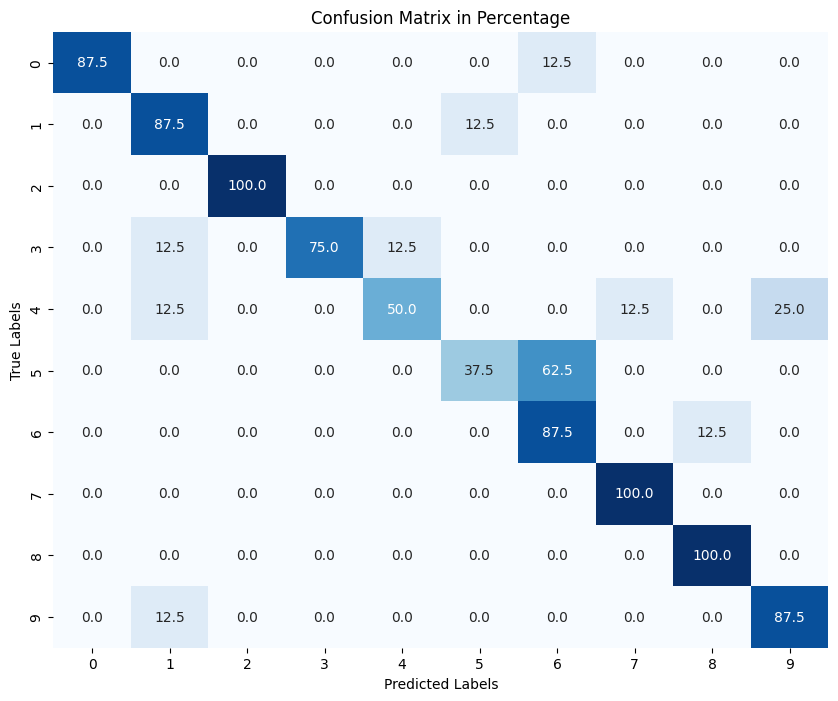

In [ ]:
train(ModifiedCNN_model, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=20)
plot_confusion_matrix(ModifiedCNN_model, test_loader, num_classes=10)